## 태양광 LSTM/ 충전시간발전량 예측하기

In [1]:
# Dataset : 믿음태양광발전소 데이터 + 기상청데이터

In [2]:
# 충전시간발전량 : y
# 다른 특성은 : X
# 여러가지 feature 바탕으로 충전시간발전량 예측
# LSTM 활용 on keras


## 데이터 불러오기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sun_weather=pd.read_csv('sun_weather.csv')

In [5]:
sun_weather.head()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
0,160701,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,...,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001
1,160702,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,...,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000
2,160703,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,...,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999
3,160704,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,...,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000
4,160705,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,...,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000


In [6]:
sun_weather.shape

(382, 84)

In [7]:
#날짜 컬럼 date데이터로 변환
sun_weather['날짜'] = pd.to_datetime(sun_weather['날짜'], format='%y%m%d')

In [8]:
sun_weather.index = sun_weather['날짜']

In [9]:
del sun_weather['날짜']

In [10]:
del sun_weather['일출시간']

In [11]:
del sun_weather['일몰시간']

In [12]:
sun_weather.head(1)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,...,24.1,23.6,24.299999,24.200001,24.700001,24.5,24.200001,22.799999,22.4,22.200001


In [13]:
sun_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382 entries, 2016-07-01 to 2017-07-17
Data columns (total 81 columns):
5Hr        382 non-null float64
6Hr        382 non-null float64
7Hr        382 non-null float64
8Hr        382 non-null float64
9Hr        382 non-null float64
10Hr       382 non-null float64
11Hr       382 non-null float64
12Hr       382 non-null float64
13Hr       382 non-null float64
14Hr       382 non-null float64
15Hr       382 non-null float64
16Hr       382 non-null float64
17Hr       382 non-null float64
18Hr       382 non-null float64
19Hr       382 non-null float64
20Hr       382 non-null int64
충전시간발전량    382 non-null float64
강수량5hr     382 non-null float64
강수량6hr     382 non-null float64
강수량7hr     382 non-null float64
강수량8hr     382 non-null float64
강수량9hr     382 non-null float64
강수량10hr    382 non-null float64
강수량11hr    382 non-null float64
강수량12hr    382 non-null float64
강수량13hr    382 non-null float64
강수량14hr    382 non-null float64
강수량15hr    382

## EDA

In [14]:
#상식적으로 일출시간, 일몰시간이 발전량과 관계없을듯. 제거해보자
#또 다른 feature들이 outlier가 없는지 등등 확인해봐야지
#이 colum(feature)들이 RNN 알고리즘에 의해 Y값을 도출하는 데 모두 사용되니까. 하나하나 정말 필요한 컬럼인지 제대로 확인해야함
#또한, 시간대별로 나누는 것이 Y값을 도출하는 데 정말로 필요한 것일까? 차라리 시간을 묶어서 강수량, 습도량, 풍속 이렇게 묶는게 낫지 않을까?
#왜냐하면 Y값은 시간대별로 나뉘어져 있지 않기 때문이다. 
#만약 시간대별로 나뉘어져 있다면, dropout 할 때, 어떤 컬럼의 가중치는 무시될텐데. 그 컬럼이 가장 높은 강수량을 포함하는 컬럼이라면 
#발전량과의 관계를 효과적으로 나타내지 못할것같음

In [15]:
#위 처럼, 논리적으로 생각하는 방법도 있는 반면, 상관관계를 그래프로 나타내면서 필요없는 컬럼을 제거할 수 있다.

In [16]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [17]:
del sun_weather['20Hr']

In [18]:
sun_weather.corr()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
5Hr,1.000000,0.321637,0.125692,0.102228,0.085458,0.076103,0.063280,0.042945,0.027075,0.004050,0.016920,0.012115,0.062369,0.085235,0.110729,0.039552,-0.013951,-0.011387,-0.015069,-0.015082,-0.015609,-0.014603,-0.012093,-0.010045,-0.012641,-0.016937,-0.009728,-0.009502,-0.016456,-0.011790,-0.015135,-0.013576,-0.016315,0.004890,0.007781,0.039047,0.039742,0.058670,0.052749,0.055084,0.068177,0.063705,0.077103,0.078967,0.083491,0.080590,0.081759,0.062145,0.004590,-0.024087,-0.075899,-0.070228,-0.061755,-0.056018,-0.060226,-0.047925,-0.049541,-0.051951,-0.023974,-0.058002,-0.067734,-0.077250,-0.066369,-0.048815,0.062948,0.056876,0.060709,0.055832,0.057665,0.056041,0.057843,0.062368,0.061920,0.063647,0.060250,0.060634,0.062023,0.061820,0.063865,0.067032
6Hr,0.321637,1.000000,0.765510,0.593065,0.436803,0.350309,0.334179,0.311095,0.288868,0.290360,0.311588,0.416703,0.550414,0.618461,0.296236,0.351790,-0.031821,-0.054394,-0.080487,-0.083992,-0.084283,-0.069409,-0.056162,-0.045488,-0.065868,-0.099251,-0.056440,-0.048916,-0.086930,-0.047844,-0.054986,-0.054777,-0.075077,-0.036625,-0.029709,0.000815,0.029372,0.048261,0.086212,0.094910,0.109310,0.112908,0.154504,0.172792,0.181355,0.200389,0.219721,0.230557,0.011829,-0.034493,-0.029607,-0.058819,-0.138225,-0.138531,-0.144183,-0.149557,-0.165567,-0.184442,-0.237420,-0.225716,-0.243281,-0.233458,-0.238729,-0.237151,0.398715,0.384992,0.377343,0.358119,0.346119,0.343609,0.330646,0.321645,0.312436,0.307713,0.296307,0.299478,0.295893,0.293181,0.288252,0.304097
7Hr,0.125692,0.765510,1.000000,0.883289,0.666345,0.522270,0.507636,0.487049,0.455320,0.461538,0.484375,0.615422,0.746237,0.666855,0.211939,0.541419,-0.090383,-0.074169,-0.104443,-0.118742,-0.136361,-0.109822,-0.093321,-0.084853,-0.102513,-0.077223,-0.062302,-0.061240,-0.047247,0.001706,0.006075,-0.005509,-0.072729,-0.035001,-0.022540,0.007681,0.050405,0.074161,0.126819,0.148406,0.165446,0.176912,0.218125,0.244089,0.266794,0.292060,0.315692,0.334170,0.000951,-0.040024,-0.030650,-0.075561,-0.217433,-0.190735,-0.231591,-0.238406,-0.283547,-0.295196,-0.360279,-0.342019,-0.349367,-0.337921,-0.340562,-0.314190,0.638226,0.622424,0.610195,0.589741,0.571089,0.559314,0.541367,0.528539,0.519931,0.516525,0.504281,0.501724,0.496027,0.493018,0.486356,0.500216
8Hr,0.102228,0.593065,0.883289,1.000000,0.844773,0.701040,0.669173,0.620102,0.598305,0.598733,0.602151,0.644708,0.696045,0.515660,0.129054,0.687913,-0.153955,-0.121893,-0.156757,-0.162453,-0.169072,-0.142532,-0.114493,-0.095666,-0.111695,-0.069227,-0.057458,-0.056532,-0.035045,0.006920,0.009961,0.005427,-0.253911,-0.219755,-0.202098,-0.164020,-0.102406,-0.075890,-0.022830,0.004371,0.032881,0.055944,0.093831,0.122503,0.146967,0.175999,0.196881,0.222117,0.046365,0.015389,0.013022,-0.063005,-0.239822,-0.187175,-0.222179,-0.222347,-0.273542,-0.287157,-0.340235,-0.328399,-0.339965,-0.329505,-0.334161,-0.311203,0.539866,0.526876,0.512009,0.485357,0.456857,0.438041,0.417457,0.404152,0.396464,0.391928,0.381383,0.376783,0.370883,0.370139,0.366201,0.376471
9Hr,0.085458,0.436803,0.666345,0.844773,1.000000,0.914032,0.852640,0.778510,0.748650,0.728646,0.674389,0.593946,0.536942,0.307895,0.005861,0.833801,-0.218082,-0.168907,-0.219792,-0.213525,-0.206364,-0.186188,-0.146612,-0.109217,-0.125075,-0.069827,-0.071977,-0.076413,-0.037633,-0.015597,-0.014112,-0.000417,-0.519017,-0.481758,-0.450930,-0.410784,-0.331365,-0.288101,-0.234375,-0.206233,-0.169927,-0.140540,-0.103836,-0.076527,-0.048738,-0.022433,-0

In [19]:
#위 데이터를 heatmap 그래프로 나타내보기
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

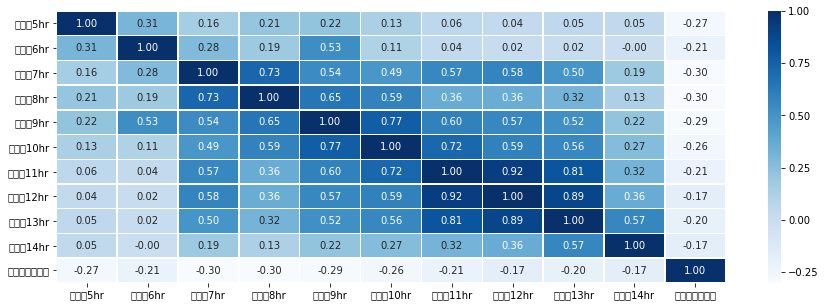

In [20]:
plt.figure(figsize=(15,5))
sns.heatmap(data=sun_weather[['강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr',
       '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr','충전시간발전량']].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

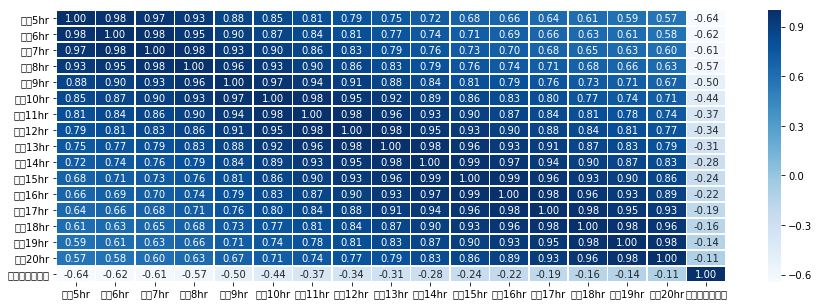

In [21]:
plt.figure(figsize=(15,5))
sns.heatmap(data=sun_weather[['습도5hr', '습도6hr',
       '습도7hr', '습도8hr', '습도9hr', '습도10hr', '습도11hr', '습도12hr', '습도13hr',
       '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr','충전시간발전량']].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

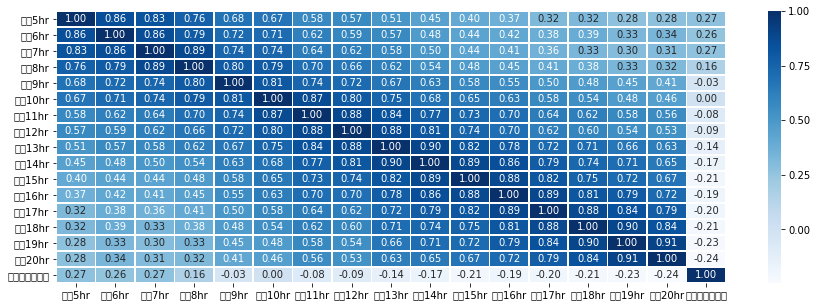

In [22]:
plt.figure(figsize=(15,5))
sns.heatmap(data=sun_weather[['풍속5hr', '풍속6hr', '풍속7hr', '풍속8hr', '풍속9hr', '풍속10hr', '풍속11hr',
       '풍속12hr', '풍속13hr', '풍속14hr', '풍속15hr', '풍속16hr', '풍속17hr', '풍속18hr',
       '풍속19hr', '풍속20hr','충전시간발전량']].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

In [23]:
# 시간대별 강수량과 발전량 관계는 무의미한것같고
# 총강수량과 발전량 관계를 보는게 더 타당해보임
# 컬럼 합해서 새로운 컬럼 만들자
sun_weather.head(2)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,1.1,7.3,1.5,0.2,0.0,140.5,3.200000,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1,1.0,0.0,93.0,94.0,95.0,95.0,94.0,93.0,92.0,91.0,90.0,91.0,92.0,93.0,94.0,94.0,95.0,96.0,4.3,2.5,2.7,1.8,2.6,2.4,3.0,1.9,1.5,1.7,3.0,3.7,4.4,5.6,4.9,4.8,22.600000,22.200001,22.299999,23.900000,24.500000,24.299999,24.100000,23.6,24.299999,24.200001,24.700001,24.5,24.200001,22.799999,22.4,22.200001
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,111.2,72.5,16.8,15.4,4.8,276.8,16.799999,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.1,0.0,0.0,96.0,96.0,94.0,93.0,95.0,94.0,95.0,96.0,95.0,96.0,95.0,95.0,90.0,96.0,95.0,96.0,1.6,1.6,3.0,4.9,5.1,2.9,1.3,0.5,1.1,3.5,2.2,1.5,2.6,1.6,1.6,0.3,22.799999,22.799999,23.200001,22.299999,21.200001,21.299999,20.299999,21.0,21.000000,20.400000,20.400000,20.6,19.900000,20.700001,20.1,20.000000


In [24]:
# # 합산 및 평균 기상데이터 컬럼 생성.
# df['하루 총 강수량'] = df.iloc[:,3:19].sum(axis=1)
# df['하루 평균 습도'] = df.iloc[:,19:35].mean(axis=1)
# df['하루 평균 풍속'] = df.iloc[:,35:51].mean(axis=1)
# df['하루 평균 기온'] = df.iloc[:,51:(51+15+1)].mean(axis=1)
# df.head()

In [25]:
sun_weather.columns

Index(['5Hr', '6Hr', '7Hr', '8Hr', '9Hr', '10Hr', '11Hr', '12Hr', '13Hr', '14Hr', '15Hr', '16Hr', '17Hr', '18Hr', '19Hr', '충전시간발전량', '강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr', '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr', '강수량15hr', '강수량16hr', '강수량17hr', '강수량18hr', '강수량19hr', '강수량20hr', '습도5hr', '습도6hr', '습도7hr', '습도8hr', '습도9hr', '습도10hr', '습도11hr', '습도12hr', '습도13hr', '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr', '풍속5hr', '풍속6hr', '풍속7hr', '풍속8hr', '풍속9hr', '풍속10hr', '풍속11hr', '풍속12hr', '풍속13hr', '풍속14hr', '풍속15hr', '풍속16hr', '풍속17hr', '풍속18hr', '풍속19hr', '풍속20hr', '기온5hr', '기온6hr', '기온7hr', '기온8hr', '기온9hr', '기온10hr', '기온11hr', '기온12hr', '기온13hr', '기온14hr', '기온15hr', '기온16hr', '기온17hr', '기온18hr', '기온19hr', '기온20hr'], dtype='object')

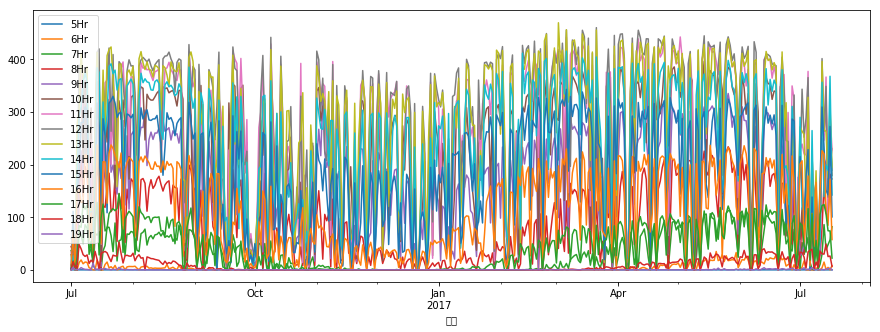

In [26]:
sun_weather[['5Hr', '6Hr', '7Hr', '8Hr', '9Hr', '10Hr', '11Hr', '12Hr', '13Hr',
       '14Hr', '15Hr', '16Hr', '17Hr', '18Hr', '19Hr']].plot(figsize=(15,5))

In [27]:
sun_weather.shape

(382, 80)

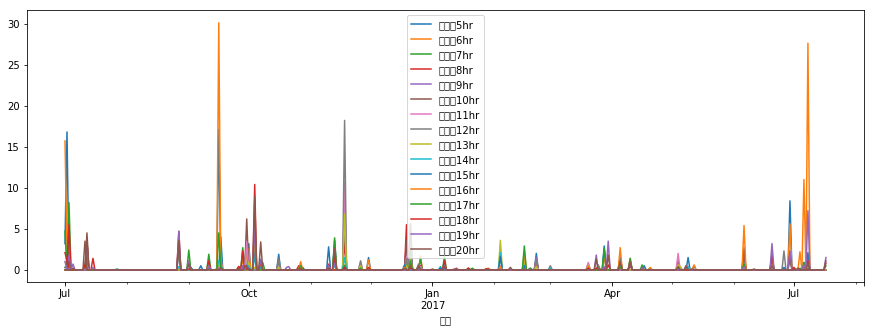

In [28]:
sun_weather[['강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr',
       '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr', '강수량15hr',
       '강수량16hr', '강수량17hr', '강수량18hr', '강수량19hr', '강수량20hr']].plot(figsize=(15,5))

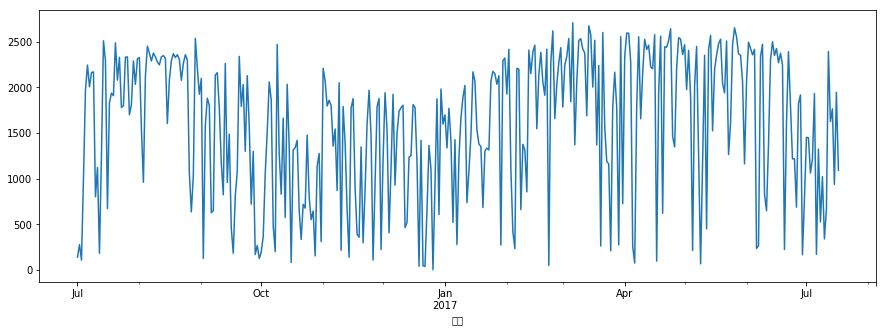

In [29]:
sun_weather.충전시간발전량.plot(figsize=(15,5))

## Exploring Data Analysis 결과

In [30]:
# 강수량과 습도만 발전량과 관계가 있어보임. 새롭게 모델짜보자

In [31]:
sun_weather.head()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,1.1,7.3,1.5,0.2,0.0,140.5,3.200000,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1,1.0,0.0,93.0,94.0,95.0,95.0,94.0,93.0,92.0,91.0,90.0,91.0,92.0,93.0,94.0,94.0,95.0,96.0,4.3,2.5,2.7,1.8,2.6,2.4,3.0,1.9,1.5,1.7,3.0,3.7,4.4,5.6,4.9,4.8,22.600000,22.200001,22.299999,23.900000,24.500000,24.299999,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,111.2,72.5,16.8,15.4,4.8,276.8,16.799999,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.1,0.0,0.0,96.0,96.0,94.0,93.0,95.0,94.0,95.0,96.0,95.0,96.0,95.0,95.0,90.0,96.0,95.0,96.0,1.6,1.6,3.0,4.9,5.1,2.9,1.3,0.5,1.1,3.5,2.2,1.5,2.6,1.6,1.6,0.3,22.799999,22.799999,23.200001,22.299999,21.200001,21.299999,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000
2016-07-03,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,3.3,0.0,0.0,0.0,4.6,0.1,107.8,0.000000,2.5,8.2,5.5,1.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,92.0,94.0,95.0,95.0,96.0,96.0,95.0,95.0,95.0,95.0,96.0,96.0,96.0,96.0,96.0,96.0,3.2,1.9,2.0,3.7,2.7,2.2,1.0,1.2,0.7,1.3,1.9,0.6,0.5,0.4,0.2,0.1,21.200001,21.000000,20.700001,20.500000,21.000000,20.799999,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999
2016-07-04,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,181.0,146.1,148.4,24.4,9.8,0.5,1012.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,87.0,86.0,90.0,91.0,92.0,94.0,95.0,96.0,96.0,95.0,95.0,96.0,96.0,96.0,96.0,2.5,1.3,2.5,2.7,0.9,1.7,2.1,0.9,0.8,0.7,0.4,0.1,0.6,0.4,0.3,0.9,24.900000,26.000000,26.400000,24.700001,24.799999,23.900000,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000
2016-07-05,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,292.2,184.8,153.4,84.0,48.0,1.0,1975.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.2,81.0,81.0,83.0,81.0,83.0,87.0,90.0,91.0,92.0,94.0,94.0,95.0,95.0,94.0,95.0,96.0,3.0,2.8,3.2,3.5,3.9,2.7,2.2,3.0,2.2,3.0,3.6,2.6,2.3,1.2,3.0,1.4,27.500000,27.700001,26.799999,27.900000,27.000000,26.400000,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000


In [32]:
sun_weather.shape

(382, 80)

In [33]:
sun_weather.loc['2017-03-25']

5Hr          0.0
6Hr          0.0
7Hr          0.0
8Hr          1.2
9Hr         13.9
10Hr        21.7
11Hr        24.5
12Hr        26.1
13Hr        14.6
14Hr        36.9
15Hr        19.3
16Hr        66.6
17Hr        54.5
18Hr         4.3
19Hr         0.0
충전시간발전량    209.7
강수량5hr       0.6
강수량6hr       0.5
강수량7hr       0.4
강수량8hr       0.0
강수량9hr       0.0
강수량10hr      0.0
강수량11hr      0.0
강수량12hr      0.0
강수량13hr      0.0
강수량14hr      0.0
강수량15hr      0.0
강수량16hr      0.0
강수량17hr      0.0
강수량18hr      0.0
           ...  
풍속7hr        2.4
풍속8hr        2.0
풍속9hr        2.8
풍속10hr       2.9
풍속11hr       0.3
풍속12hr       0.5
풍속13hr       0.4
풍속14hr       0.2
풍속15hr       0.7
풍속16hr       1.1
풍속17hr       0.4
풍속18hr       0.7
풍속19hr       0.5
풍속20hr       0.3
기온5hr        7.8
기온6hr        7.8
기온7hr        7.6
기온8hr        8.7
기온9hr        8.0
기온10hr       7.5
기온11hr       6.5
기온12hr       5.5
기온13hr       6.0
기온14hr       5.3
기온15hr       4.7
기온16hr       5.2
기온17hr       4.7
기온18hr       4

In [34]:
# 382 * 0.7

In [35]:
train = sun_weather.loc[:'2017-03-25']
test = sun_weather.loc['2017-03-25':]

In [36]:
train.shape

(268, 80)

In [37]:
test.shape

(115, 80)

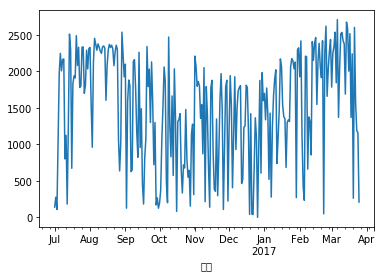

In [38]:
ax = train.충전시간발전량.plot()

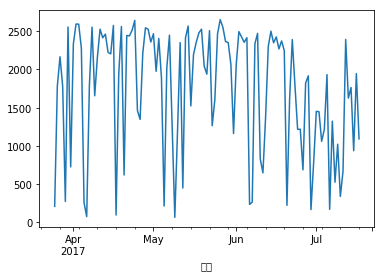

In [39]:
test.충전시간발전량.plot()

In [40]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [41]:
train.head()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,1.1,7.3,1.5,0.2,0.0,140.5,3.200000,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1,1.0,0.0,93.0,94.0,95.0,95.0,94.0,93.0,92.0,91.0,90.0,91.0,92.0,93.0,94.0,94.0,95.0,96.0,4.3,2.5,2.7,1.8,2.6,2.4,3.0,1.9,1.5,1.7,3.0,3.7,4.4,5.6,4.9,4.8,22.600000,22.200001,22.299999,23.900000,24.500000,24.299999,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,111.2,72.5,16.8,15.4,4.8,276.8,16.799999,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.1,0.0,0.0,96.0,96.0,94.0,93.0,95.0,94.0,95.0,96.0,95.0,96.0,95.0,95.0,90.0,96.0,95.0,96.0,1.6,1.6,3.0,4.9,5.1,2.9,1.3,0.5,1.1,3.5,2.2,1.5,2.6,1.6,1.6,0.3,22.799999,22.799999,23.200001,22.299999,21.200001,21.299999,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000
2016-07-03,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,3.3,0.0,0.0,0.0,4.6,0.1,107.8,0.000000,2.5,8.2,5.5,1.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,92.0,94.0,95.0,95.0,96.0,96.0,95.0,95.0,95.0,95.0,96.0,96.0,96.0,96.0,96.0,96.0,3.2,1.9,2.0,3.7,2.7,2.2,1.0,1.2,0.7,1.3,1.9,0.6,0.5,0.4,0.2,0.1,21.200001,21.000000,20.700001,20.500000,21.000000,20.799999,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999
2016-07-04,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,181.0,146.1,148.4,24.4,9.8,0.5,1012.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,87.0,86.0,90.0,91.0,92.0,94.0,95.0,96.0,96.0,95.0,95.0,96.0,96.0,96.0,96.0,2.5,1.3,2.5,2.7,0.9,1.7,2.1,0.9,0.8,0.7,0.4,0.1,0.6,0.4,0.3,0.9,24.900000,26.000000,26.400000,24.700001,24.799999,23.900000,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000
2016-07-05,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,292.2,184.8,153.4,84.0,48.0,1.0,1975.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.2,81.0,81.0,83.0,81.0,83.0,87.0,90.0,91.0,92.0,94.0,94.0,95.0,95.0,94.0,95.0,96.0,3.0,2.8,3.2,3.5,3.9,2.7,2.2,3.0,2.2,3.0,3.6,2.6,2.3,1.2,3.0,1.4,27.500000,27.700001,26.799999,27.900000,27.000000,26.400000,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000


In [42]:
test.head()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25,0.0,0.0,0.0,1.2,13.9,21.7,24.5,26.1,14.6,36.9,19.3,66.6,54.5,4.3,0.0,209.7,0.6,0.5,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,92.0,89.0,82.0,81.0,83.0,86.0,89.0,88.0,88.0,88.0,88.0,89.0,87.0,84.0,88.0,2.9,2.9,2.4,2.0,2.8,2.9,0.3,0.5,0.4,0.2,0.7,1.1,0.4,0.7,0.5,0.3,7.8,7.8,7.6,8.7,8.0,7.5,6.5,5.5,6.0,5.3,4.7,5.2,4.7,4.4,4.2,3.5
2017-03-26,0.0,0.2,43.6,122.7,206.9,349.4,375.5,340.8,301.4,250.6,105.8,61.3,57.4,5.7,0.0,1784.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,49.0,46.0,49.0,53.0,55.0,61.0,69.0,73.0,75.0,76.0,78.0,82.0,82.0,82.0,78.0,3.6,4.0,3.7,4.1,3.4,3.6,3.9,3.6,1.8,2.9,3.1,2.8,3.0,0.6,1.4,1.1,11.2,10.6,10.8,9.7,9.1,8.1,7.6,6.7,6.3,6.6,6.3,6.0,5.6,5.3,6.1,6.4
2017-03-27,0.0,0.0,29.4,99.4,108.0,242.1,293.6,419.4,351.7,373.9,291.8,193.2,81.7,4.9,0.0,2165.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,43.0,40.0,40.0,40.0,47.0,53.0,65.0,69.0,75.0,77.0,82.0,81.0,85.0,87.0,90.0,5.2,5.5,5.1,4.0,3.6,2.9,2.5,1.3,1.1,0.9,2.8,2.0,2.5,1.8,0.1,0.3,11.9,12.3,12.0,11.4,10.7,9.4,8.8,6.8,6.7,5.5,6.3,5.5,5.7,4.7,3.4,2.7
2017-03-28,0.0,0.2,47.6,163.2,279.8,366.3,376.1,319.0,293.3,245.1,101.3,78.8,41.6,3.7,0.0,1779.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,2.5,2.9,1.7,2.6,0.2,0.4,0.0,42.0,44.0,45.0,42.0,54.0,56.0,58.0,61.0,71.0,86.0,88.0,90.0,90.0,89.0,89.0,88.0,3.3,3.6,1.7,2.3,1.2,0.9,0.5,0.3,0.7,1.6,0.4,0.7,2.8,2.8,2.4,2.9,13.5,13.0,12.1,12.6,11.1,10.4,9.6,9.3,8.7,8.9,8.1,7.5,7.4,7.4,7.4,7.3
2017-03-29,0.0,0.0,0.0,2.2,5.7,22.8,34.7,38.7,55.1,56.4,38.0,28.3,13.7,0.0,0.0,274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,79.0,79.0,80.0,81.0,81.0,82.0,84.0,87.0,86.0,85.0,85.0,84.0,84.0,84.0,86.0,4.0,3.7,2.9,3.1,2.5,2.1,2.0,0.1,0.5,0.4,2.4,1.8,2.6,2.7,1.4,0.4,10.4,10.3,10.3,10.1,10.2,10.3,10.5,10.1,8.9,8.4,9.4,8.8,8.3,7.9,7.1,6.5


In [43]:
train_sc = sc.fit_transform(train)
# train_sc

In [44]:
test_sc = sc.transform(test)
# test_sc

In [45]:
test_sc.max()

1.8563829787234043

In [46]:
test_sc.min()

-0.18965517241379315

In [47]:
train_sc.max()

1.0000000000000002

In [48]:
train_sc.min()

0.0

In [49]:
train_sc_df = pd.DataFrame(train_sc, columns= train.columns, index=train.index)
train_sc_df.head(2)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,0.132979,0.414141,0.211027,0.089433,0.156135,0.076749,0.019991,0.060490,0.003129,0.003208,0.030750,0.010331,0.003802,0.000000,0.051589,0.190476,1.000000,0.573171,0.0,0.0,0.0,0.028302,0.0,0.0,0.0,0.0,0.0,0.046154,0.201923,0.188679,0.0,0.961039,0.975904,1.000000,1.000000,0.943662,0.954545,0.938462,0.888889,0.883333,0.901639,0.933333,0.950820,0.96875,0.969231,0.983051,0.982759,0.451613,0.202128,0.313253,0.202532,0.192593,0.269663,0.384615,0.218391,0.192308,0.226667,0.384615,0.435294,0.444444,0.651163,0.538462,0.410256,0.686335,0.679128,0.690625,0.740964,0.791541,0.830721,0.842444,0.837209,0.869565,0.886598,0.910653,0.920690,0.909091,0.871287,0.870130,0.850794
2016-07-02,0.0,0.388298,0.273850,0.143061,0.096172,0.150079,0.002490,0.003911,0.012567,0.065704,0.324293,0.305392,0.115702,0.292776,0.372093,0.101959,1.000000,0.159236,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.105769,0.000000,0.0,1.000000,1.000000,0.986667,0.972603,0.957746,0.969697,0.984615,0.968254,0.966667,0.983607,0.983333,0.983607,0.90625,1.000000,0.983051,0.982759,0.161290,0.106383,0.349398,0.594937,0.377778,0.325843,0.166667,0.057471,0.141026,0.466667,0.282051,0.176471,0.262626,0.186047,0.175824,0.025641,0.692547,0.697819,0.718750,0.692771,0.691843,0.736677,0.720257,0.750831,0.759197,0.756014,0.762887,0.786207,0.764310,0.801980,0.795455,0.780952


In [50]:
test_sc_df = pd.DataFrame(test_sc, columns= test.columns, index=test.index)
test_sc_df.head(2)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25,0.0,0.000000,0.000000,0.005703,0.042573,0.057135,0.055468,0.056714,0.031097,0.088809,0.056285,0.280539,0.375344,0.081749,0.0,0.077162,0.035714,0.031847,0.04878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948052,0.951807,0.920000,0.821918,0.760563,0.803030,0.846154,0.857143,0.85,0.852459,0.866667,0.868852,0.890625,0.861538,0.796610,0.844828,0.301075,0.244681,0.277108,0.227848,0.207407,0.325843,0.038462,0.057471,0.051282,0.026667,0.089744,0.129412,0.040404,0.081395,0.054945,0.025641,0.226708,0.230530,0.23125,0.283133,0.293051,0.304075,0.276527,0.235880,0.257525,0.237113,0.223368,0.255172,0.252525,0.264026,0.279221,0.257143
2017-03-26,0.0,0.010638,0.489338,0.583175,0.633691,0.919958,0.850125,0.740548,0.641960,0.603129,0.308545,0.258214,0.395317,0.108365,0.0,0.659239,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.337662,0.433735,0.346667,0.369863,0.366197,0.378788,0.461538,0.539683,0.60,0.639344,0.666667,0.704918,0.781250,0.784615,0.762712,0.672414,0.376344,0.361702,0.433735,0.493671,0.251852,0.404494,0.500000,0.413793,0.230769,0.386667,0.397436,0.329412,0.303030,0.069767,0.153846,0.094017,0.332298,0.317757,0.33125,0.313253,0.326284,0.322884,0.311897,0.275748,0.267559,0.281787,0.278351,0.282759,0.282828,0.293729,0.340909,0.349206


In [51]:
# test_sc_df.isnull().sum()

In [52]:
# test_sc_df.충전시간발전량

In [53]:
X_train = train_sc_df.dropna().drop('충전시간발전량', axis=1)
y_train = train_sc_df.dropna()[['충전시간발전량']]

In [54]:
X_train.head(1)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,0.132979,0.414141,0.211027,0.089433,0.156135,0.076749,0.019991,0.06049,0.003129,0.003208,0.03075,0.010331,0.003802,0.0,0.190476,1.0,0.573171,0.0,0.0,0.0,0.028302,0.0,0.0,0.0,0.0,0.0,0.046154,0.201923,0.188679,0.0,0.961039,0.975904,1.0,1.0,0.943662,0.954545,0.938462,0.888889,0.883333,0.901639,0.933333,0.95082,0.96875,0.969231,0.983051,0.982759,0.451613,0.202128,0.313253,0.202532,0.192593,0.269663,0.384615,0.218391,0.192308,0.226667,0.384615,0.435294,0.444444,0.651163,0.538462,0.410256,0.686335,0.679128,0.690625,0.740964,0.791541,0.830721,0.842444,0.837209,0.869565,0.886598,0.910653,0.92069,0.909091,0.871287,0.87013,0.850794


In [55]:
y_train.head(1)

,충전시간발전량
날짜,
2016-07-01,0.051589


In [56]:
X_test = test_sc_df.dropna().drop('충전시간발전량', axis=1)
# y_test = test_sc_df.dropna().충전시간발전량
y_test = test_sc_df.dropna()[['충전시간발전량']]

In [57]:
X_test.head(1)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25,0.0,0.0,0.0,0.005703,0.042573,0.057135,0.055468,0.056714,0.031097,0.088809,0.056285,0.280539,0.375344,0.081749,0.0,0.035714,0.031847,0.04878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948052,0.951807,0.92,0.821918,0.760563,0.80303,0.846154,0.857143,0.85,0.852459,0.866667,0.868852,0.890625,0.861538,0.79661,0.844828,0.301075,0.244681,0.277108,0.227848,0.207407,0.325843,0.038462,0.057471,0.051282,0.026667,0.089744,0.129412,0.040404,0.081395,0.054945,0.025641,0.226708,0.23053,0.23125,0.283133,0.293051,0.304075,0.276527,0.23588,0.257525,0.237113,0.223368,0.255172,0.252525,0.264026,0.279221,0.257143


In [58]:
y_test.head(1)

,충전시간발전량
날짜,
2017-03-25,0.077162


In [59]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [60]:
# keras에서는 RNN계열의 모델을 트레이닝할 때 요구되는 데이터의 형식이 있다.
# 바로 3차원 데이터여야하며, 각각의 차원은(size, timestep, feature)

In [61]:
X_train.shape

(268, 79)

In [62]:
X_train_t = X_train.reshape(X_train.shape[0], 79, 1)
X_test_t = X_test.reshape(X_test.shape[0], 79, 1)

In [63]:
X_train_t.shape

(268, 79, 1)

In [64]:
X_test_t.shape

(115, 79, 1)

In [65]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [66]:
K.clear_session()
model = Sequential()
model.add(LSTM(20, input_shape=(79,1))) # shape는 차원맞추는 것
model.add(Dense(1))  #Dense : output 개수 

In [67]:
X_train_t.shape

(268, 79, 1)

In [68]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs = 100, batch_size=30, verbose=1)

Epoch 1/100
268/268 [==============================] - 1s 3ms/step - loss: 0.4092
Epoch 2/100
268/268 [==============================] - 0s 975us/step - loss: 0.2758
Epoch 3/100
268/268 [==============================] - 0s 1ms/step - loss: 0.1765
Epoch 4/100
268/268 [==============================] - 0s 1ms/step - loss: 0.1168
Epoch 5/100
268/268 [==============================] - 0s 949us/step - loss: 0.1097
Epoch 6/100
268/268 [==============================] - 0s 964us/step - loss: 0.1008
Epoch 7/100
268/268 [==============================] - 0s 1ms/step - loss: 0.0961
Epoch 8/100
268/268 [==============================] - 0s 975us/step - loss: 0.0922
Epoch 9/100
268/268 [==============================] - 0s 1ms/step - loss: 0.0878
Epoch 10/100
268/268 [==============================] - 0s 960us/step - loss: 0.0849
Epoch 11/100
268/268 [==============================] - 0s 1ms/step - loss: 0.0829
Epoch 12/100
268/268 [==============================] - 0s 986us/step - loss: 0.0811
E

268/268 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 100/100
268/268 [==============================] - 0s 1ms/step - loss: 0.0093


In [69]:
y_pred = model.predict(X_test_t)

In [70]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [71]:
from math import sqrt

In [72]:
rmse = sqrt(mean_squared_error(y_test, y_pred))

In [73]:
rmse

0.16037591116825872

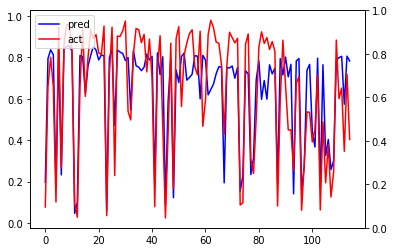

In [74]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

pred = y_pred

loss_ax.plot(pred, 'b', label='pred')

loss_ax.plot(y_test, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()

In [75]:
model50 = Sequential()
model50.add(Dense(79, input_dim = 79, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(300, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(500, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(300, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(1))
# model50.compile(loss='mean_squared_error', optimizer='rmsprop')
model50.compile(loss='mean_squared_error', optimizer='adam')

hist = model50.fit(X_train, y_train, epochs=50, batch_size=10)
model50.evaluate(X_test, y_test)
yhat = model50.predict(X_test)
rmse2 = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse2)


Epoch 1/50
268/268 [==============================] - 1s 2ms/step - loss: 0.5958
Epoch 2/50
268/268 [==============================] - 0s 547us/step - loss: 0.0837
Epoch 3/50
268/268 [==============================] - 0s 566us/step - loss: 0.0498
Epoch 4/50
268/268 [==============================] - 0s 584us/step - loss: 0.0450
Epoch 5/50
268/268 [==============================] - 0s 610us/step - loss: 0.0418
Epoch 6/50
268/268 [==============================] - 0s 607us/step - loss: 0.0378
Epoch 7/50
268/268 [==============================] - 0s 577us/step - loss: 0.0351
Epoch 8/50
268/268 [==============================] - 0s 588us/step - loss: 0.0300
Epoch 9/50
268/268 [==============================] - 0s 618us/step - loss: 0.0300
Epoch 10/50
268/268 [==============================] - 0s 581us/step - loss: 0.0240
Epoch 11/50
268/268 [==============================] - 0s 584us/step - loss: 0.0261
Epoch 12/50
268/268 [==============================] - 0s 595us/step - loss: 0.0283
Epo

In [76]:
from math import sqrt

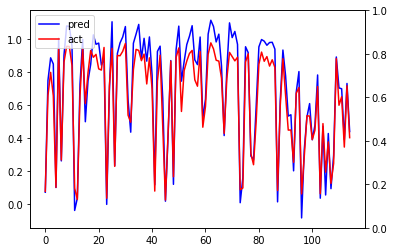

In [77]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

pred = y_pred

loss_ax.plot(yhat, 'b', label='pred')

loss_ax.plot(y_test, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()

In [78]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback): 
    def init(self): 
        self.losses = [] 
    def on_epoch_end(self, batch, logs={}): 
        self.losses.append(logs.get('loss')) 

In [79]:
history = LossHistory()  
history.init() 
 
model50.fit(X_train, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[history]) 

Epoch 1/100
268/268 [==============================] - 0s 212us/step - loss: 0.0074
Epoch 2/100
268/268 [==============================] - 0s 212us/step - loss: 0.0065
Epoch 3/100
268/268 [==============================] - 0s 238us/step - loss: 0.0070
Epoch 4/100
268/268 [==============================] - 0s 231us/step - loss: 0.0058
Epoch 5/100
268/268 [==============================] - 0s 231us/step - loss: 0.0063
Epoch 6/100
268/268 [==============================] - 0s 212us/step - loss: 0.0071
Epoch 7/100
268/268 [==============================] - 0s 220us/step - loss: 0.0053
Epoch 8/100
268/268 [==============================] - 0s 208us/step - loss: 0.0053
Epoch 9/100
268/268 [==============================] - 0s 212us/step - loss: 0.0057
Epoch 10/100
268/268 [==============================] - 0s 234us/step - loss: 0.0059
Epoch 11/100
268/268 [==============================] - 0s 227us/step - loss: 0.0053
Epoch 12/100
268/268 [==============================] - 0s 220us/step - lo

268/268 [==============================] - 0s 223us/step - loss: 0.0036
Epoch 98/100
268/268 [==============================] - 0s 190us/step - loss: 0.0031
Epoch 99/100
268/268 [==============================] - 0s 216us/step - loss: 0.0037
Epoch 100/100
268/268 [==============================] - 0s 197us/step - loss: 0.0036


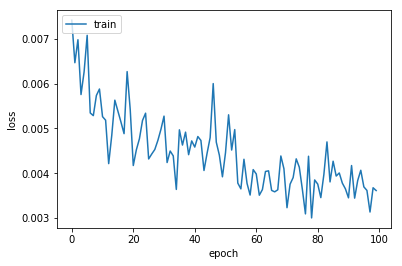

In [80]:
# 학습 시각화 
%matplotlib inline 
import matplotlib.pyplot as plt 
 
plt.plot(history.losses) 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train'], loc='upper left')
plt.show() 